In [ ]:
alice = []

with open ("./cantrbry/alice29.txt", "r") as f :
    alice = f.read()

lcet = []

with open ("./cantrbry/lcet10.txt", "r") as f :
    lcet = f.read()

plrabn12 = []

with open ("./cantrbry/plrabn12.txt", "r") as f :
    plrabn12 = f.read()

asyoulik = []

with open ("./cantrbry/asyoulik.txt", "r") as f :
    asyoulik = f.read()


In [ ]:
#@title read binary files

kennedy = []
ptt5 = []
sum_file = []

with open ("./kennedy.xls", "rb") as f :
    kennedy = f.read()

with open ("./ptt5", "rb") as f :
    ptt5 = f.read()

with open ("./sum", "rb") as f :
    byte = f.read(1)
    while byte:
        sum_file.append(byte)
        # Read the next byte
        byte = f.read(1)


In [1]:
#@title Model: linear

TOTAL_CHAR = 2**8
import random

# derivative first half (log P(s) / alpha)

import sys
import pickle
import math
import pdb
import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=400)

# n = 4   # number of letters as context
MAX_N = 4
MAX_UPDATE_RATIO = 0.4
MINIMUM_ALPHA = 1e-10

class Blending_with_linear_param:
    max_f = 0
    max_d = 0
    total_score = 0
    count = 0
    logs = []
    logs_score_individual = []
    zero_prob = 0
    n_gram_model = {}
    learning_rate = 0.003

    def __init__(self, max_f, max_d, learning_rate):
        self.max_f = max_f
        self.max_d = max_d
        self.logs = []
        self.logs_score_individual = []
        self.zero_prob = 0
        self.total_score = 0
        self.n_gram_model = {}
        self.learning_rate = learning_rate
        return None

    def derivative_of_P_to_alpha(self, alpha_matrix, beta_matrix, prefix, x):
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)
        if prefix in self.n_gram_model:
            ms = sum(self.n_gram_model[prefix].values())
            us = len(self.n_gram_model[prefix])
            if x in self.n_gram_model[prefix]:
                ms_x = self.n_gram_model[prefix][x]
            else:
                ms_x = 0
        else:
            ms = 0
            us = 0
            ms_x = 0
        if prefix in self.n_gram_model and x in self.n_gram_model[prefix]:
            eq1 = (beta-ms_x) / (ms+alpha)**2
        else:
            eq1 = 0

        if len(prefix) == 0:
            eq2 = (ms-us*beta) / (ms+alpha)**2 / TOTAL_CHAR
            eq3 = 0
        else:
            next_prefix = prefix[1:]
            eq2 = (ms-us*beta) / (ms+alpha)**2 * self.blend(alpha_matrix, beta_matrix, next_prefix, x)
            eq3 = (alpha + us*beta) / (ms+alpha) * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, next_prefix, x)

        return eq1 + eq2 + eq3

    def derivative_of_P_to_beta(self, alpha_matrix, beta_matrix, prefix, x):
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)
        if prefix in self.n_gram_model:
            ms = sum(self.n_gram_model[prefix].values())
            us = len(self.n_gram_model[prefix])
            if x in self.n_gram_model[prefix]:
                ms_x = self.n_gram_model[prefix][x]
            else:
                ms_x = 0
        else:
            ms = 0
            us = 0
            ms_x = 0
        if prefix in self.n_gram_model and x in self.n_gram_model[prefix]:
            eq1 = -1 / (ms+alpha)
        else:
            eq1 = 0

        if len(prefix) == 0:
            eq2 = us / (ms+alpha)/ TOTAL_CHAR
            eq3 = 0
        else:
            next_prefix = prefix[1:]
            eq2 = us / (ms+alpha) * self.blend(alpha_matrix, beta_matrix, next_prefix, x)
            eq3 = (alpha + us*beta) / (ms+alpha) * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, next_prefix, x)

        return (eq1 + eq2 + eq3)


    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate

        n = len(prefix)
        if n > self.max_d:
            n = self.max_d

        # add a computation for alpha beta
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f
        param_derivative_mapping = [1, f]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        if prob == 0:
            return
        allowed_beta_minimum = 0
        allowed_beta_maximum = 1

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[n][0] + max(0, alpha_matrix[n][1]*self.max_f)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[n][0] + min(0, alpha_matrix[n][1]*self.max_f)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_minimum = (beta_matrix[n][0] + min(0, beta_matrix[n][1]*self.max_f)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = (beta_matrix[n][0] + max(0, beta_matrix[n][1]*self.max_f)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        # # print(allowed_alpha_minimum, allowed_alpha_maximum)

        # old_alpha_0 = alpha_matrix[n][0]
        # old_alpha_1 = alpha_matrix[n][1]
        # old_beta_0 = beta_matrix[n][0]
        # old_beta_1 = beta_matrix[n][1]

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[n][ind] += beta_update * derivative
            alpha_matrix[n][ind] += alpha_update * derivative

        # if n == 5:
        #     print(allowed_alpha_minimum, allowed_alpha_maximum)
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # restrict param for beta
        beta_matrix[n][0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[n][0]))

        if beta_matrix[n][0] + self.max_f * beta_matrix[n][1] > allowed_beta_maximum:
            beta_matrix[n][1] = (allowed_beta_maximum - beta_matrix[n][0]) / self.max_f
        elif beta_matrix[n][0] + self.max_f * beta_matrix[n][1] < allowed_beta_minimum:
            beta_matrix[n][1] = (allowed_beta_minimum-beta_matrix[n][0]) / self.max_f

        # max_beta = max(beta_matrix[n][0], beta_matrix[n][0]+self.max_f*beta_matrix[n][1])
        # restrict param for alpha
        alpha_matrix[n][0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[n][0]))

        if alpha_matrix[n][0] + self.max_f * alpha_matrix[n][1] < allowed_alpha_minimum:
            alpha_matrix[n][1] = (allowed_alpha_minimum-alpha_matrix[n][0]) / self.max_f
        elif alpha_matrix[n][0] + self.max_f * alpha_matrix[n][1] > allowed_alpha_maximum:
            alpha_matrix[n][1] = (allowed_alpha_maximum-alpha_matrix[n][0]) / self.max_f

        # if beta_update == 0 or alpha_update == 0:
        #     return

        # # compute factor
        # if f == 0:
        #     factor = min((alpha_matrix[n][0] - old_alpha_0) / (alpha_update), (beta_matrix[n][0] - old_beta_0) / (beta_update),)
        # else:
        #     factor = min((alpha_matrix[n][0] - old_alpha_0) / (alpha_update), (alpha_matrix[n][1] - old_alpha_1) / (alpha_update*f),
        #                 (beta_matrix[n][0] - old_beta_0) / (beta_update), (beta_matrix[n][1] - old_beta_1) / (beta_update*f))

        # assert(factor > 0)


    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        n = len(prefix)
        if n > self.max_d:
            n = self.max_d

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        param_derivative_mapping = [1, f]

        alpha = alpha_matrix[n][0] + f * alpha_matrix[n][1]
        beta = beta_matrix[n][0] + f * beta_matrix[n][1]

        return (alpha, beta)

    def build_model_with_train(self, data, alpha_matrix, beta_matrix, n):
        """
        Build n-gram model of the words in  words_lang.txt
        """
        # read in all n+1 grams
        word_org = data
        # update n-gram
        # word = "^" * n + word + "$"
        for i in range(len(data) - n):

            n_plus_1_gram = data[i:i + n + 1]
            score = self.letter_prob_score (alpha_matrix, beta_matrix, n_plus_1_gram[:-1], n_plus_1_gram[-1], n)
            self.total_score += score
            # self.total_score += self.blend (alpha_matrix, beta_matrix, n_plus_1_gram[:-1], n_plus_1_gram[-1], n_grams, n)
            self.count += 1
            self.logs.append(-self.total_score/self.count)
            self.logs_score_individual.append(score)

            # n_plus_1_gram = word[i:i + n + 1]
            # for N in range(n, -1, -1):
            #     x = n_plus_1_gram[-1]
            #     next_n = n_plus_1_gram[:-1]

            #     self.update_param(alpha_matrix, beta_matrix, next_n, x, n_grams)

            #     n_plus_1_gram = n_plus_1_gram[1:]

            n_plus_1_gram = data[i:i + n + 1]
            for N in range(n+1):
                x = n_plus_1_gram[-1]
                next_n = n_plus_1_gram[-1-N:-1]
                self.update_param(alpha_matrix, beta_matrix, next_n, x)



            n_plus_1_gram = data[i:i + n + 1]
            for N in range(n, -1, -1):
                x = n_plus_1_gram[-1]
                next_n = n_plus_1_gram[:-1]

                if next_n not in self.n_gram_model:
                    self.n_gram_model[next_n] = {}

                if x not in self.n_gram_model[next_n]:
                    self.n_gram_model[next_n][x] = 1
                else:
                    self.n_gram_model[next_n][x] += 1

                n_plus_1_gram = n_plus_1_gram[1:]


        return self.n_gram_model

    def offline_optimisation(self, data, alpha_matrix, beta_matrix, word_file, n):
         for word in data:
            for i in range(len(word) - n):
                n_plus_1_gram = word[i:i + n + 1]
                for N in range(n+1):
                    x = n_plus_1_gram[-1]
                    next_n = n_plus_1_gram[-1-N:-1]
                    self.update_param(alpha_matrix, beta_matrix, next_n, x)

    def blend(self, alpha_matrix, beta_matrix, prefix, x):
        prob = 0

        # compute alpha and beta
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)
        possible_x = TOTAL_CHAR

        # first half of algorithm
        if prefix in self.n_gram_model:
            us = len(self.n_gram_model[prefix])
            ms = sum(self.n_gram_model[prefix].values())
            base = (len(self.n_gram_model[prefix])*beta + alpha) / (sum(self.n_gram_model[prefix].values()) + alpha)
            if x in self.n_gram_model[prefix]:
                prob += (self.n_gram_model[prefix][x] - beta) / (sum(self.n_gram_model[prefix].values()) + alpha)
        else:
            base = (0 + alpha) / (0 + alpha)

        if len(prefix) == 0:
            prob += base / possible_x
        else:
            prev = self.blend(alpha_matrix, beta_matrix, prefix[1:], x)
            prob += base * prev

        prob = prob

        return prob


    def word_prob_blend(self, alpha_matrix, beta_matrix, word, n):
        word = "^" * n + word.strip() + "$"
        pos = n  # char after n ^
        log_likelihood = 0
        # print ("   ", end="")
        while pos < len(word):
            prefix = word[pos - n:pos]
            prob = self.blend(alpha_matrix, beta_matrix, prefix, word[pos])
            # print(prefix, word[pos], prob)
            if prob:
                log_likelihood += math.log2(prob)
            pos += 1


        return log_likelihood / (len(word) - 1)  # didn't guess "^"

    def letter_prob_score(self, alpha_matrix, beta_matrix, prefix, x, n):
        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        # print(prefix, word[pos], prob)
        if prob:
            return math.log2(prob)
        else:
            self.zero_prob += 1
            print("error")
            return 0


In [2]:
#@title Model: linear v2

class Blending_with_linear_param_v2(Blending_with_linear_param):
    max_f = 0
    max_n = 0

    def __init__(self, max_f, max_n, learning_rate):
        self.max_n = max_n
        super().__init__(max_f, max_n, learning_rate)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate

        n = len(prefix)
        if n > self.max_d:
            n = self.max_d

        # add a computation for alpha beta
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f
        param_derivative_mapping = [1, f, n]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        if prob == 0:
            return

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[0] + max(0, alpha_matrix[1]*self.max_f) + max(0, alpha_matrix[2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[0] + min(0, alpha_matrix[1]*self.max_f) + min(0, alpha_matrix[2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_maximum = (beta_matrix[0] + max(0, beta_matrix[1]*self.max_f) + max(0, beta_matrix[2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_minimum = (beta_matrix[0] + min(0, beta_matrix[1]*self.max_f) + min(0, beta_matrix[2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[ind] += beta_update * derivative
            alpha_matrix[ind] += alpha_update * derivative

        # restrict param for beta
        beta_matrix[0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[0]))

        if beta_matrix[0] + self.max_f * beta_matrix[1] > allowed_beta_maximum:
            beta_matrix[1] = (allowed_beta_maximum - beta_matrix[0]) / self.max_f
        elif beta_matrix[0] + self.max_f * beta_matrix[1] < allowed_beta_minimum:
            beta_matrix[1] = (allowed_beta_minimum-beta_matrix[0]) / self.max_f

        if beta_matrix[0] + max(self.max_f * beta_matrix[1], 0) + beta_matrix[2]*self.max_n > allowed_beta_maximum:
            beta_matrix[2] = (allowed_beta_maximum - beta_matrix[0] - max(self.max_f * beta_matrix[1], 0)) / self.max_n
        elif beta_matrix[0] + min(self.max_f * beta_matrix[1], 0) + beta_matrix[2]*self.max_n < allowed_beta_minimum:
            beta_matrix[2] = (allowed_beta_minimum - beta_matrix[0] - min(self.max_f * beta_matrix[1], 0)) / self.max_n

        # restrict param for alpha
        alpha_matrix[0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[0]))

        if alpha_matrix[0] + self.max_f * alpha_matrix[1] < allowed_alpha_minimum:
            alpha_matrix[1] = (allowed_alpha_minimum-alpha_matrix[0]) / self.max_f
        elif alpha_matrix[0] + self.max_f * alpha_matrix[1] > allowed_alpha_maximum:
            alpha_matrix[1] = (allowed_alpha_maximum-alpha_matrix[0]) / self.max_f

        if alpha_matrix[0] + max(self.max_f * alpha_matrix[1], 0) + alpha_matrix[2]*self.max_n > allowed_alpha_maximum:
            alpha_matrix[2] = (allowed_alpha_maximum - alpha_matrix[0] - max(self.max_f * alpha_matrix[1], 0)) / self.max_n
        elif alpha_matrix[0] + min(self.max_f * alpha_matrix[1], 0) + alpha_matrix[2]*self.max_n < allowed_alpha_minimum:
            alpha_matrix[2] = (allowed_alpha_minimum - alpha_matrix[0] - min(self.max_f * alpha_matrix[1], 0)) / self.max_n



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        n = len(prefix)
        if n > self.max_d:
            n = self.max_d

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        param_derivative_mapping = [1, f, n]
        # alpha1 = np.dot(alpha_matrix[n], param_derivative_mapping)
        # beta1 = np.dot(beta_matrix[n], param_derivative_mapping)

        alpha = alpha_matrix[0] + f * alpha_matrix[1] + n * alpha_matrix[2]
        beta = beta_matrix[0] + f* beta_matrix[1] + n * beta_matrix[2]

        #beta = max(0, min(1, beta))
        # alpha = max(-beta, alpha)

        return (alpha, beta)



In [3]:
#@title Model: linear v2 with piecewise linear on d

class Blending_with_linear_param_v2_piecewise_d(Blending_with_linear_param):
    max_f = 0
    d_split = 0

    def __init__(self, max_f, max_d, d_split, learning_rate):
        self.d_split = d_split
        super().__init__(max_f, max_d, learning_rate)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        n = len(prefix)
        # add a computation for alpha beta
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if n < self.d_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        if prob == 0:
            return

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[d][0] + max(0, alpha_matrix[d][1]*self.max_f) + max(0, alpha_matrix[d][2]*self.max_d)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[d][0] + min(0, alpha_matrix[d][1]*self.max_f) + min(0, alpha_matrix[d][2]*self.max_d)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_maximum = (beta_matrix[d][0] + max(0, beta_matrix[d][1]*self.max_f) + max(0, beta_matrix[d][2]*self.max_d)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_minimum = (beta_matrix[d][0] + min(0, beta_matrix[d][1]*self.max_f) + min(0, beta_matrix[d][2]*self.max_d)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[d][ind] += beta_update * derivative
            alpha_matrix[d][ind] += alpha_update * derivative

        # restrict param for beta
        beta_matrix[d][0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[d][0]))

        if beta_matrix[d][0] + self.max_f * beta_matrix[d][1] > allowed_beta_maximum:
            beta_matrix[d][1] = (allowed_beta_maximum - beta_matrix[d][0]) / self.max_f
        elif beta_matrix[d][0] + self.max_f * beta_matrix[d][1] < allowed_beta_minimum:
            beta_matrix[d][1] = (allowed_beta_minimum-beta_matrix[d][0]) / self.max_f

        if beta_matrix[d][0] + max(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_d > allowed_beta_maximum:
            beta_matrix[d][2] = (allowed_beta_maximum - beta_matrix[d][0] - max(self.max_f * beta_matrix[d][1], 0)) / self.max_d
        elif beta_matrix[d][0] + min(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_d < allowed_beta_minimum:
            beta_matrix[d][2] = (allowed_beta_minimum - beta_matrix[d][0] - min(self.max_f * beta_matrix[d][1], 0)) / self.max_d

        # restrict param for alpha
        alpha_matrix[d][0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[d][0]))

        if alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] < allowed_alpha_minimum:
            alpha_matrix[d][1] = (allowed_alpha_minimum-alpha_matrix[d][0]) / self.max_f
        elif alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] > allowed_alpha_maximum:
            alpha_matrix[d][1] = (allowed_alpha_maximum-alpha_matrix[d][0]) / self.max_f

        if alpha_matrix[d][0] + max(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_d > allowed_alpha_maximum:
            alpha_matrix[d][2] = (allowed_alpha_maximum - alpha_matrix[d][0] - max(self.max_f * alpha_matrix[d][1], 0)) / self.max_d
        elif alpha_matrix[d][0] + min(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_d < allowed_alpha_minimum:
            alpha_matrix[d][2] = (allowed_alpha_minimum - alpha_matrix[d][0] - min(self.max_f * alpha_matrix[d][1], 0)) / self.max_d



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        n = len(prefix)
        if n > self.max_d:
            n = self.max_d

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if n < self.d_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]

        alpha = alpha_matrix[d][0] + f * alpha_matrix[d][1] + n * alpha_matrix[d][2]
        beta = beta_matrix[d][0] + f* beta_matrix[d][1] + n * beta_matrix[d][2]

        return (alpha, beta)



In [4]:
#@title Model: linear v2 with piecewise linear on f

class Blending_with_linear_param_v2_piecewise_f(Blending_with_linear_param):
    max_f = 0
    f_split = 0

    def __init__(self, max_f, max_d, f_split, learning_rate):
        self.f_split = f_split
        super().__init__(max_f, max_d, learning_rate)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        n = len(prefix)
        # add a computation for alpha beta
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if f < self.f_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        if prob == 0:
            return

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[d][0] + max(0, alpha_matrix[d][1]*self.max_f) + max(0, alpha_matrix[d][2]*self.max_d)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[d][0] + min(0, alpha_matrix[d][1]*self.max_f) + min(0, alpha_matrix[d][2]*self.max_d)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_maximum = (beta_matrix[d][0] + max(0, beta_matrix[d][1]*self.max_f) + max(0, beta_matrix[d][2]*self.max_d)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_minimum = (beta_matrix[d][0] + min(0, beta_matrix[d][1]*self.max_f) + min(0, beta_matrix[d][2]*self.max_d)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[d][ind] += beta_update * derivative
            alpha_matrix[d][ind] += alpha_update * derivative

        # restrict param for beta
        beta_matrix[d][0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[d][0]))

        if beta_matrix[d][0] + self.max_f * beta_matrix[d][1] > allowed_beta_maximum:
            beta_matrix[d][1] = (allowed_beta_maximum - beta_matrix[d][0]) / self.max_f
        elif beta_matrix[d][0] + self.max_f * beta_matrix[d][1] < allowed_beta_minimum:
            beta_matrix[d][1] = (allowed_beta_minimum-beta_matrix[d][0]) / self.max_f

        if beta_matrix[d][0] + max(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_d > allowed_beta_maximum:
            beta_matrix[d][2] = (allowed_beta_maximum - beta_matrix[d][0] - max(self.max_f * beta_matrix[d][1], 0)) / self.max_d
        elif beta_matrix[d][0] + min(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_d < allowed_beta_minimum:
            beta_matrix[d][2] = (allowed_beta_minimum - beta_matrix[d][0] - min(self.max_f * beta_matrix[d][1], 0)) / self.max_d

        # restrict param for alpha
        alpha_matrix[d][0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[d][0]))

        if alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] < allowed_alpha_minimum:
            alpha_matrix[d][1] = (allowed_alpha_minimum-alpha_matrix[d][0]) / self.max_f
        elif alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] > allowed_alpha_maximum:
            alpha_matrix[d][1] = (allowed_alpha_maximum-alpha_matrix[d][0]) / self.max_f

        if alpha_matrix[d][0] + max(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_d > allowed_alpha_maximum:
            alpha_matrix[d][2] = (allowed_alpha_maximum - alpha_matrix[d][0] - max(self.max_f * alpha_matrix[d][1], 0)) / self.max_d
        elif alpha_matrix[d][0] + min(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_d < allowed_alpha_minimum:
            alpha_matrix[d][2] = (allowed_alpha_minimum - alpha_matrix[d][0] - min(self.max_f * alpha_matrix[d][1], 0)) / self.max_d



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        n = len(prefix)
        if n > self.max_d:
            n = self.max_d

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if f < self.f_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        # alpha1 = np.dot(alpha_matrix[n], param_derivative_mapping)
        # beta1 = np.dot(beta_matrix[n], param_derivative_mapping)

        alpha = alpha_matrix[d][0] + f * alpha_matrix[d][1] + n * alpha_matrix[d][2]
        beta = beta_matrix[d][0] + f* beta_matrix[d][1] + n * beta_matrix[d][2]

        #beta = max(0, min(1, beta))
        # alpha = max(-beta, alpha)

        return (alpha, beta)



In [5]:
#@title Model: trainer with 1 alpha and beta for all calculation

class Blending_with_one_alpha_beta(Blending_with_linear_param):

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        d = len(prefix)
        n = d
        d = 0
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[0][0] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[0][0] * MAX_UPDATE_RATIO), 1)

        factor = max(factor_alpha, factor_beta)



        beta_matrix[0][0] += beta_update / factor
        alpha_matrix[0][0] += alpha_update / factor

        beta_matrix[0][0] = max(MINIMUM_ALPHA, min(1, beta_matrix[0][0]))
        alpha_matrix[0][0] = max(MINIMUM_ALPHA, alpha_matrix[0][0])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):

        return (alpha_matrix[0][0], beta_matrix[0][0])

In [6]:
#@title Model: trainer with 2d matrix for d and f

class Blending_with_2d_matrix(Blending_with_linear_param):
    alpha_trend = []
    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        d = len(prefix)
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if d > self.max_d:
            d = self.max_d

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        alpha_update = learning_rate * derivative_alpha
        # print(alpha_update)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[d][f] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[d][f] * MAX_UPDATE_RATIO), 1)
        # factor = max(factor_alpha, factor_beta)

        beta_matrix[d][f] += beta_update / factor_beta
        alpha_matrix[d][f] += alpha_update / factor_alpha

        beta_matrix[d][f] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][f]))
        alpha_matrix[d][f] = max(MINIMUM_ALPHA, alpha_matrix[d][f])
        # print("new", alpha_matrix[d][f], beta_matrix[d][f])


    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        d = len(prefix)
        if d > self.max_d:
            d = self.max_d

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        return (alpha_matrix[d][f], beta_matrix[d][f])

In [7]:
#@title Model: trainer with 2d matrix for d and m

class Blending_with_2d_matrix_v2(Blending_with_linear_param):
    max_m = 0

    def __init__(self, max_f, max_d, max_m, learning_rate):
        self.max_m = max_m
        super().__init__(max_f, max_d, learning_rate)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        d = len(prefix)
        if prefix in self.n_gram_model:
            m = sum(self.n_gram_model[prefix].values())
        else:
            m = 0

        if m > self.max_m:
            m = self.max_m

        if d > self.max_d:
            d = self.max_d

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[d][m] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[d][m] * MAX_UPDATE_RATIO), 1)

        factor = max(factor_alpha, factor_beta)



        beta_matrix[d][m] += beta_update / factor
        alpha_matrix[d][m] += alpha_update / factor

        beta_matrix[d][m] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][m]))
        alpha_matrix[d][m] = max(MINIMUM_ALPHA, alpha_matrix[d][m])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        d = len(prefix)
        if d > self.max_d:
            d = self.max_d

        if prefix in self.n_gram_model:
            m = sum(self.n_gram_model[prefix].values())
        else:
            m = 0

        if m > self.max_m:
            m = self.max_m

        return (alpha_matrix[d][m], beta_matrix[d][m])

In [8]:
#@title Model: trainer with 3d matrix for d and f and m

class Blending_with_2d_matrix_v3(Blending_with_linear_param):
    max_m = 0

    def __init__(self, max_f, max_d, max_m, learning_rate):
        self.max_m = max_m
        super().__init__(max_f, max_d, learning_rate)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        d = len(prefix)

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if prefix in self.n_gram_model:
            m = sum(self.n_gram_model[prefix].values())
        else:
            m = 0

        if m > self.max_m:
            m = self.max_m

        if d > self.max_d:
            d = self.max_d

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[d][f][m] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[d][f][m] * MAX_UPDATE_RATIO), 1)

        factor = max(factor_alpha, factor_beta)



        beta_matrix[d][f][m] += beta_update / factor
        alpha_matrix[d][f][m] += alpha_update / factor

        beta_matrix[d][f][m] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][f][m]))
        alpha_matrix[d][f][m] = max(MINIMUM_ALPHA, alpha_matrix[d][f][m])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix):
        d = len(prefix)
        if d > self.max_d:
            d = self.max_d

        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if prefix in self.n_gram_model:
            m = sum(self.n_gram_model[prefix].values())
        else:
            m = 0

        if m > self.max_m:
            m = self.max_m

        return (alpha_matrix[d][f][m], beta_matrix[d][f][m])

In [9]:
#@title Model: constant alpha and beta

import matplotlib.pyplot as plt

# Your list of numbers
def plot_score(data, x, y, title):
    plt.clf()
    # Plotting the list of numbers
    plt.plot(data)

    # Adding labels to the plot
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)

    # Display the plot
    plt.show()

class Blending_with_no_training(Blending_with_2d_matrix):
    logs = []

    def update_param(self, alpha_matrix, beta_matrix, prefix, x):
        learning_rate = self.learning_rate
        d = len(prefix)
        n = d
        if prefix in self.n_gram_model:
            f = len(self.n_gram_model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        beta_matrix[d][f] += beta_update
        alpha_matrix[d][f] += alpha_update

        beta_matrix[d][f] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][f]))
        alpha_matrix[d][f] = max(MINIMUM_ALPHA, alpha_matrix[d][f])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])

    def build_model_with_train(self, data, alpha_matrix, beta_matrix, n):
        # read in all n+1 grams
        word_org = data
        # update n-gram
        for i in range(len(data) - n):
            n_plus_1_gram = data[i:i + n + 1]
            score = self.letter_prob_score (alpha_matrix, beta_matrix, n_plus_1_gram[:-1], n_plus_1_gram[-1], n)
            self.total_score += score
            self.count += 1
            self.logs.append(-self.total_score/self.count)
            self.logs_score_individual.append(score)

            n_plus_1_gram = data[i:i + n + 1]
            for N in range(n, -1, -1):
                x = n_plus_1_gram[-1]
                next_n = n_plus_1_gram[:-1]

                if next_n not in self.n_gram_model:
                    self.n_gram_model[next_n] = {}

                if x not in self.n_gram_model[next_n]:
                    self.n_gram_model[next_n][x] = 1
                else:
                    self.n_gram_model[next_n][x] += 1

                n_plus_1_gram = n_plus_1_gram[1:]




        return self.n_gram_model

In [13]:
input_string = "aabb"
utf8_encoded = input_string.encode('utf-8')
utf8_encoded
binary_list = ['{:08b}'.format(byte) for byte in utf8_encoded]

binary_string = binary_list[0]
binary_integer = int(binary_string, 2)
hexadecimal_representation = hex(binary_integer)

In [14]:
hexadecimal_representation

'0x61'

In [16]:
data

('01100001', '01100001', '01100010', '01100010')

constant value avg score: 3.382250876274166


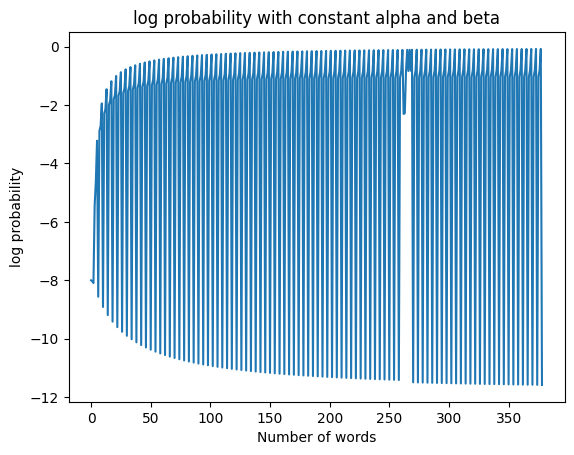

training end, matrix(2d matrix for d and f) avg score: 3.280748432026425


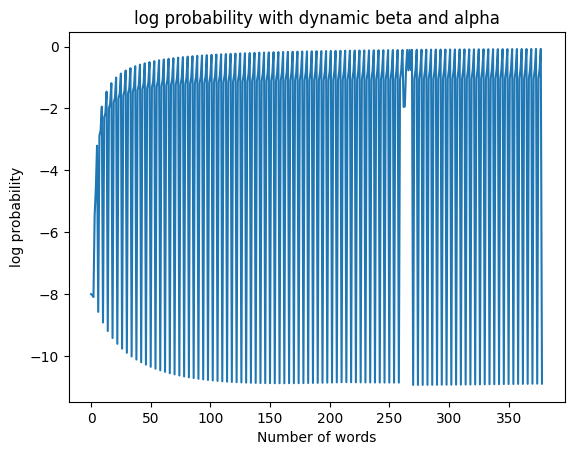

In [18]:
#@title dynamic alpha and beta

MAX_F = 5
MAX_M = 100
learning_rate = 0.003

n = 1
# data = [alice]

# data = [''.join(["aba"+chr(i) for i in range(32, 127)])]
data = ''.join(["aba" + chr(i) for i in range(32, 127)])

utf8_encoded = data.encode('utf-8')
binary_list = ['{:08b}'.format(byte) for byte in utf8_encoded]

data = tuple(binary_list)

alpha_matrix = [[10 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

alpha_matrix_untrained = [[10 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_untrained = Blending_with_no_training(MAX_F, n, learning_rate)
trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
plot_score(trainer_untrained.logs_score_individual, 'Number of words', 'log probability', 'log probability with constant alpha and beta')

for i in range(1):
    trainer_matrix = Blending_with_2d_matrix(MAX_F, n, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    plot_score(trainer_matrix.logs_score_individual, 'Number of words', 'log probability', 'log probability with dynamic beta and alpha')



constant value avg score: 5.397209407092712
training end, matrix(2d matrix for d and f) avg score: 5.331308505868692


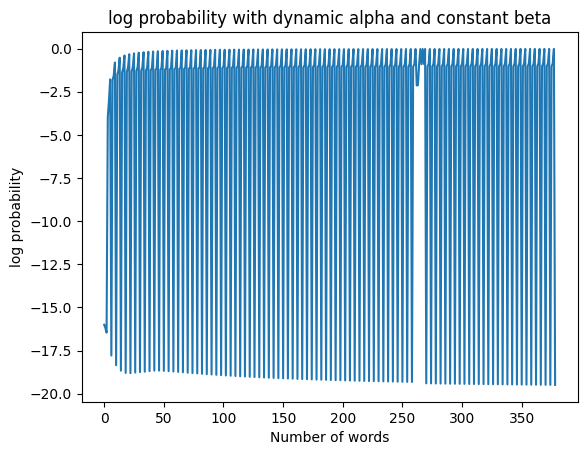

In [ ]:
#@title dynamic alpha and constant beta

MAX_F = 5
MAX_M = 100
learning_rate = 0.003

n = 1
# data = [alice]

# data = [''.join(["aba"+chr(i) for i in range(32, 127)])]
data = ''.join(["aba" + chr(i) for i in range(32, 127)])

alpha_matrix = [[1 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

alpha_matrix_untrained = [[1 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_untrained = Blending_with_no_training(MAX_F, n, learning_rate)
trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
# plot_score(trainer_untrained.logs_score_individual, 'Number of words', 'log probability', 'log probability with constant alpha and beta')

for i in range(1):
    trainer_matrix = Blending_with_2d_matrix(MAX_F, n, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    plot_score(trainer_matrix.logs_score_individual, 'Number of words', 'log probability', 'log probability with dynamic alpha and constant beta')



training end, matrix(2d matrix for d and f) avg score: 5.753862979986945


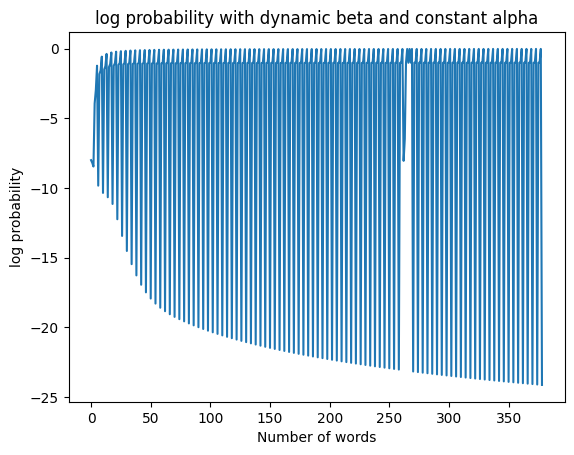

In [ ]:
#@title dynamic beta and constant alpha

MAX_F = 5
MAX_M = 100
learning_rate = 0.003

n = 1
# data = [alice]

# data = [''.join(["aba"+chr(i) for i in range(32, 127)])]
data = ''.join(["aba" + chr(i) for i in range(32, 127)])

alpha_matrix = [[1 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

alpha_matrix_untrained = [[1 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_untrained = Blending_with_no_training(MAX_F, n, learning_rate)
trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
# print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
# plot_score(trainer_untrained.logs_score_individual, 'Number of words', 'log probability', 'log probability with constant alpha and beta')

for i in range(1):
    trainer_matrix = Blending_with_2d_matrix(MAX_F, n, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    plot_score(trainer_matrix.logs_score_individual, 'Number of words', 'log probability', 'log probability with dynamic beta and constant alpha')



In [ ]:
#@title verify
MAX_F = 15
n = 5
MAX_N = n

# load data
data = [alice[:1000]]


# alpha_matrix = [[0.5, 0, 0] for _ in range(n+1)]
# beta_matrix = [[0.75, 0, 0] for _ in range(n+1)]

alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_1 = Blending_with_2d_matrix(MAX_F, MAX_N, 0.003)
n_gram_model_1 = trainer_1.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)

# verify
cand = [chr(i) for i in range(ord('A'), ord('Z') + 1)] + [chr(i) for i in range(ord('a'), ord('z') + 1)] + ["$"]

# alpha_matrix = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
# beta_matrix = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
def verify(trainer, prefix, model):
    s = 0
    for c in cand:
        prob = trainer.blend(alpha_matrix, beta_matrix, prefix, c)
        assert(prob > 0 and prob <=1)
        s += prob

    return s

print(verify(trainer_1, "ralvc", n_gram_model_1))
print(verify(trainer_1, "^allc", n_gram_model_1))
print(verify(trainer_1, "trumc", n_gram_model_1))
print(verify(trainer_1, "russc", n_gram_model_1))
print(verify(trainer_1, "kochc", n_gram_model_1))
print(verify(trainer_1, "racka", n_gram_model_1))

0.9729503305033382
0.9729503305033382
0.9729503305033382
0.9729503305033382
0.9729503305033382
0.9286857116215051


In [ ]:
#@title Sample Usage: try compression on alice

# Hyper-parameter settings
MAX_F = 11
MAX_M = 100
n = 8
MAX_N = n
learning_rate = 0.003

# specify the data
data = alice

alpha_matrix = [[10 for _ in range(MAX_F+1)] for _ in range(MAX_N+1)]
beta_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_N+1)]

trainer_matrix = Blending_with_2d_matrix(MAX_F, MAX_N, learning_rate)
trainer_matrix.alpha_trend = []
n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
# plot_score(trainer_matrix.logs)

alpha_matrix_linear = [[10, 0] for _ in range(MAX_N+1)]
beta_matrix_linear = [[0.75, 0] for _ in range(MAX_N+1)]

trainer_linear = Blending_with_linear_param(MAX_F, MAX_N, learning_rate)
n_gram_model_linear = trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
# plot_score(trainer_linear.logs)

training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.288849608707172
training end, linear(alpha = p0d + p1d * f) avg score: 2.235479155450066


In [ ]:
#@title Sample Usage: words from different texts

import random
MAX_F = 11
MAX_M = 100
n = 8
MAX_D = 6
learning_rate = 0.003

print("runing on text files")

texts = {"alice29": alice, "lcet10": lcet, "plrabn12": plrabn12, "asyoulik": asyoulik}
# load data
for id in texts:

    data = texts[id]
    print(f"runing on file: {id}")
    print()

    alpha_matrix_linear = [[0.5]]
    beta_matrix_linear = [[0.75]]

    trainer_one_param = Blending_with_one_alpha_beta(MAX_F, MAX_D, learning_rate)
    n_gram_model_linear = trainer_one_param.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, one param(1 alpha and beta for all calculation) avg score: {-trainer_one_param.total_score/trainer_one_param.count}")
    # plot_score(trainer_one_param.logs)

    alpha_matrix_linear = [[0.5, 0] for _ in range(MAX_D+1)]
    beta_matrix_linear = [[0.75, 0] for _ in range(MAX_D+1)]

    trainer_linear = Blending_with_linear_param(MAX_F, MAX_D, learning_rate)
    n_gram_model_linear = trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)

    alpha_matrix_linear = [0.5, 0, 0]
    beta_matrix_linear = [0.75, 0, 0]

    trainer_linear_v2 = Blending_with_linear_param_v2(MAX_F, MAX_D, learning_rate)
    n_gram_model_linear = trainer_linear_v2.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2.total_score/trainer_linear_v2.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, MAX_D, 1, learning_rate)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, MAX_D, 2, learning_rate)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_f(MAX_F, MAX_D, 1, learning_rate)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F, MAX_D, learning_rate)
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_D+1)]

    trainer_matrix_v2 = Blending_with_2d_matrix_v2(MAX_F, MAX_D, MAX_M, learning_rate)
    n_gram_model_matrix = trainer_matrix_v2.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix v2(2d matrix for d and m) avg score: {-trainer_matrix_v2.total_score/trainer_matrix_v2.count}")
    # plot_score(trainer_matrix_v2.logs)

    alpha_matrix = [[[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_matrix_v3 = Blending_with_2d_matrix_v3(MAX_F, MAX_D, MAX_M, learning_rate)
    n_gram_model_matrix = trainer_matrix_v3.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix v3(3d matrix for d, f, m) avg score: {-trainer_matrix_v3.total_score/trainer_matrix_v3.count}")
    # plot_score(trainer_matrix_v3.logs)

    alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_untrained = Blending_with_no_training(MAX_F, MAX_D, learning_rate)
    n_gram_model_untrained = trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on text files
runing on file: alice29

training end, one param(1 alpha and beta for all calculation) avg score: 3.3001882120760677
training end, linear(alpha = p0d + p1d * f) avg score: 2.205289547430286
training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: 2.2174724073669783
training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: 2.239200812907027
training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: 2.30212813526153
training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: 2.192841942552072
training end, matrix(2d matrix for d and f) avg score: 2.4765854297301737
training end, matrix v2(2d matrix for d and m) avg score: 3.6429055813870566
training end, matrix v3(3d matrix for d, f, m) avg score: 3.477130588455324
constant value avg score: 2.4623900874062503

runing on file: lcet10

training end, one param(1 alpha and beta for all calculation) avg 

In [ ]:
#@title try repeat compression on asyoulik

MAX_F = 11
MAX_M = 100
n = 8
learning_rate = 0.03

data = [asyoulik]

alpha_matrix = [[10 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]

alpha_matrix_linear = [[10, 0] for _ in range(n+1)]
beta_matrix_linear = [[0.75, 0] for _ in range(n+1)]
# plot_score(trainer_matrix.logs)
for i in range(5):
    print("iter", i)

    data = alice

    trainer_matrix = Blending_with_2d_matrix(MAX_F, learning_rate)
    trainer_matrix.alpha_trend = []
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)



    trainer_linear = Blending_with_linear_param(MAX_F, learning_rate)
    n_gram_model_linear = trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)

iter 0
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.301309730499128
training end, linear(alpha = p0d + p1d * f) avg score: 2.2356767724679263
iter 1
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.272196677644992
training end, linear(alpha = p0d + p1d * f) avg score: 2.2992846899742245
iter 2
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.257498297575527
training end, linear(alpha = p0d + p1d * f) avg score: 2.3479919948761205
iter 3
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.246361617314264
training end, linear(alpha = p0d + p1d * f) avg score: 2.3678244814179017
iter 4
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.237116257308087
training end, linear(alpha = p0d + p1d * f) avg score: 2.377335595063113


In [ ]:
#@title words from alice, dynamic alpha and beta

import random
MAX_F = 11
MAX_M = 100
n = 8
MAX_D = 7
learning_rate = 0.003

print("runing on text files")

# texts = {"alice29": alice, "lcet10": lcet, "plrabn12": plrabn12, "asyoulik": asyoulik}
texts = {"alice29": alice}
# load data
for id in texts:

    data = texts[id]
    print(f"runing on file: {id}")
    print()

    alpha_matrix_linear = [[0.5]]
    beta_matrix_linear = [[0.75]]

    trainer_one_param = Blending_with_one_alpha_beta(MAX_F, MAX_D, learning_rate)
    trainer_one_param.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, one param(1 alpha and beta for all calculation) avg score: {-trainer_one_param.total_score/trainer_one_param.count}")
    # plot_score(trainer_one_param.logs)

    alpha_matrix_linear = [[0.5, 0] for _ in range(MAX_D+1)]
    beta_matrix_linear = [[0.75, 0] for _ in range(MAX_D+1)]

    trainer_linear = Blending_with_linear_param(MAX_F, MAX_D, learning_rate)
    trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)

    alpha_matrix_linear = [0.5, 0, 0]
    beta_matrix_linear = [0.75, 0, 0]

    trainer_linear_v2 = Blending_with_linear_param_v2(MAX_F, MAX_D, learning_rate)
    trainer_linear_v2.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2.total_score/trainer_linear_v2.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, MAX_D, 1, learning_rate)
    trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, MAX_D, 2, learning_rate)
    trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_f(MAX_F, MAX_D, 1, learning_rate)
    trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F, MAX_D, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_D+1)]

    trainer_matrix_v2 = Blending_with_2d_matrix_v2(MAX_F, MAX_D, MAX_M, learning_rate)
    trainer_matrix_v2.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix v2(2d matrix for d and m) avg score: {-trainer_matrix_v2.total_score/trainer_matrix_v2.count}")
    # plot_score(trainer_matrix_v2.logs)

    alpha_matrix = [[[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_matrix_v3 = Blending_with_2d_matrix_v3(MAX_F, MAX_D, MAX_M, learning_rate)
    trainer_matrix_v3.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix v3(3d matrix for d, f, m) avg score: {-trainer_matrix_v3.total_score/trainer_matrix_v3.count}")
    # plot_score(trainer_matrix_v3.logs)

    alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_untrained = Blending_with_no_training(MAX_F, MAX_D, learning_rate)
    trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on text files
runing on file: alice29

training end, one param(1 alpha and beta for all calculation) avg score: 2.269517362239207
training end, linear(alpha = p0d + p1d * f) avg score: 2.2211319685567976
training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: 2.199817316370472
training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: 2.2010269766001453
training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: 2.198881615960179
training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: 2.192664553673427
training end, matrix(2d matrix for d and f) avg score: 2.389545760251975
training end, matrix v2(2d matrix for d and m) avg score: 2.4087836690639572
training end, matrix v3(3d matrix for d, f, m) avg score: 2.4191805424956847
constant value avg score: 2.4623900874062503



In [ ]:
#@title words from alice, dynamic alpha and constant beta

import random
MAX_F = 11
MAX_M = 100
n = 8
MAX_D = 7
learning_rate = 0.003

print("runing on text files")

# texts = {"alice29": alice, "lcet10": lcet, "plrabn12": plrabn12, "asyoulik": asyoulik}
texts = {"alice29": alice}
# load data
for id in texts:

    data = texts[id]
    print(f"runing on file: {id}")
    print()

    alpha_matrix_linear = [[0.5]]
    beta_matrix_linear = [[0.75]]

    trainer_one_param = Blending_with_one_alpha_beta(MAX_F, MAX_D, learning_rate)
    trainer_one_param.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, one param(1 alpha and beta for all calculation) avg score: {-trainer_one_param.total_score/trainer_one_param.count}")
    # plot_score(trainer_one_param.logs)

    alpha_matrix_linear = [[0.5, 0] for _ in range(MAX_D+1)]
    beta_matrix_linear = [[0.75, 0] for _ in range(MAX_D+1)]

    trainer_linear = Blending_with_linear_param(MAX_F, MAX_D, learning_rate)
    trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)

    alpha_matrix_linear = [0.5, 0, 0]
    beta_matrix_linear = [0.75, 0, 0]

    trainer_linear_v2 = Blending_with_linear_param_v2(MAX_F, MAX_D, learning_rate)
    trainer_linear_v2.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2.total_score/trainer_linear_v2.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, MAX_D, 1, learning_rate)
    trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, MAX_D, 2, learning_rate)
    trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_f(MAX_F, MAX_D, 1, learning_rate)
    trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F, MAX_D, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_D+1)]

    trainer_matrix_v2 = Blending_with_2d_matrix_v2(MAX_F, MAX_D, MAX_M, learning_rate)
    trainer_matrix_v2.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix v2(2d matrix for d and m) avg score: {-trainer_matrix_v2.total_score/trainer_matrix_v2.count}")
    # plot_score(trainer_matrix_v2.logs)

    alpha_matrix = [[[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix = [[[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_matrix_v3 = Blending_with_2d_matrix_v3(MAX_F, MAX_D, MAX_M, learning_rate)
    trainer_matrix_v3.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix v3(3d matrix for d, f, m) avg score: {-trainer_matrix_v3.total_score/trainer_matrix_v3.count}")
    # plot_score(trainer_matrix_v3.logs)

    alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
    beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

    trainer_untrained = Blending_with_no_training(MAX_F, MAX_D, learning_rate)
    trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on text files
runing on file: alice29

training end, one param(1 alpha and beta for all calculation) avg score: 2.8707573856870794
training end, linear(alpha = p0d + p1d * f) avg score: 2.8189385585852538
training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: 3.085739661895135
training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: 3.287650989737517
training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: 3.3033853462067055
training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: 2.993828712358989
training end, matrix(2d matrix for d and f) avg score: 2.419605443704602
training end, matrix v2(2d matrix for d and m) avg score: 2.393137077158454
training end, matrix v3(3d matrix for d, f, m) avg score: 2.4175730870431464
constant value avg score: 2.4666009182437447



In [ ]:
#nn@title repeat compression on alice with dynamic alpha and beta

import random
MAX_F = 11
MAX_M = 100
n = 8
MAX_D = 7
learning_rate = 0.03

print("runing on text files")

texts = {"alice29": alice}


alpha_matrix_linear = [[0.5, 0] for _ in range(MAX_D+1)]
beta_matrix_linear = [[0.75, 0] for _ in range(MAX_D+1)]

alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

# load data
for i in range(8):

    data = texts["alice29"]
    print(f"runing on iter: {i}")
    print()

    trainer_linear = Blending_with_linear_param(MAX_F, MAX_D, learning_rate)
    trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)



    trainer_matrix = Blending_with_2d_matrix(MAX_F, MAX_D, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)



    trainer_untrained = Blending_with_no_training(MAX_F, MAX_D, learning_rate)
    trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on text files
runing on iter: 0

training end, linear(alpha = p0d + p1d * f) avg score: 2.174607697134569
training end, matrix(2d matrix for d and f) avg score: 2.3380721901675923
constant value avg score: 2.4623900874062503

runing on iter: 1

training end, linear(alpha = p0d + p1d * f) avg score: 2.177811672755407
training end, matrix(2d matrix for d and f) avg score: 2.2868748137665116
constant value avg score: 2.4623900874062503

runing on iter: 2

training end, linear(alpha = p0d + p1d * f) avg score: 2.183960584855818
training end, matrix(2d matrix for d and f) avg score: 2.2647705679890406
constant value avg score: 2.4623900874062503

runing on iter: 3

training end, linear(alpha = p0d + p1d * f) avg score: 2.188325443387148
training end, matrix(2d matrix for d and f) avg score: 2.2511926273042793
constant value avg score: 2.4623900874062503

runing on iter: 4

training end, linear(alpha = p0d + p1d * f) avg score: 2.191783439131843
training end, matrix(2d matrix for d an

In [ ]:
#@title repeat compression on alice with dynamic alpha and constant beta

import random
MAX_F = 11
MAX_M = 100
n = 8
MAX_D = 7
learning_rate = 0.003

print("runing on text files")

texts = {"alice29": alice}


alpha_matrix_linear = [[0.5, 0] for _ in range(MAX_D+1)]
beta_matrix_linear = [[0.75, 0] for _ in range(MAX_D+1)]

alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]
beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(MAX_D+1)]

# load data
for i in range(4):

    data = texts["alice29"]
    print(f"runing on iter: {i}")
    print()

    trainer_linear = Blending_with_linear_param(MAX_F, MAX_D, learning_rate)
    trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)



    trainer_matrix = Blending_with_2d_matrix(MAX_F, MAX_D, learning_rate)
    trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)



    trainer_untrained = Blending_with_no_training(MAX_F, MAX_D, learning_rate)
    trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on text files
runing on iter: 0

training end, linear(alpha = p0d + p1d * f) avg score: 2.8189385585852538
training end, matrix(2d matrix for d and f) avg score: 2.419605443704602
constant value avg score: 2.4666009182437447

runing on iter: 1

training end, linear(alpha = p0d + p1d * f) avg score: 3.0922692395760696
training end, matrix(2d matrix for d and f) avg score: 2.4951052792922566
constant value avg score: 2.4666009182437447

runing on iter: 2

training end, linear(alpha = p0d + p1d * f) avg score: 3.15923471530505
training end, matrix(2d matrix for d and f) avg score: 2.5513171255342626
constant value avg score: 2.4666009182437447

runing on iter: 3

training end, linear(alpha = p0d + p1d * f) avg score: 3.1959247860623123
training end, matrix(2d matrix for d and f) avg score: 2.587484260695528
constant value avg score: 2.4666009182437447

